## Image Segmentation

This project aims at separating subjects and backgrounds in greyscale images. We have tried to convert this image segmentation problem into a mix max flow rate problem and solve this using network graphs and optimization techniques. We have considered one source node that will be the source of water, that will flow into one node of the network, then to the neighbours and finally to the node that is connected to target / sink. 

The source node is ONLY connected to the one pixel in the background, and water can ONLY flow from the source node to the background pixel (not in reverse), and the sink node is only connected to the one pixel in the foreground, and water can ONLY flow from the foreground pixel to the sink node."

This setup is crucial for the max flow / min cut algorithm to work correctly in image segmentation. By connecting the source to a known background pixel and the sink to a known foreground pixel, we create a flow network that, when solved, will reveal the optimal cut separating the background from the foreground.

We used both scenarios:
- 4-neighbours
- 8-neighbours

### Images Used

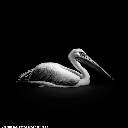  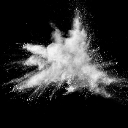 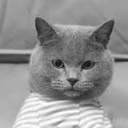 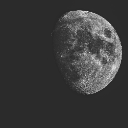

## 4 - Neighbours

The following code considers only the top, bottom, left and right neighbours of each pixel. All the tasks are functionalised. The user could tweak and run the following to generate the output:

#### Variable Declaration - User I/Ps
- file_path = 'cat128x128.png'  # Input file path
- sigma = 0.001  
- background_pixel = (0, 0)  # Background pixel loc
- foreground_pixel = (70, 70)  # Foreground pixel loc

#### Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26


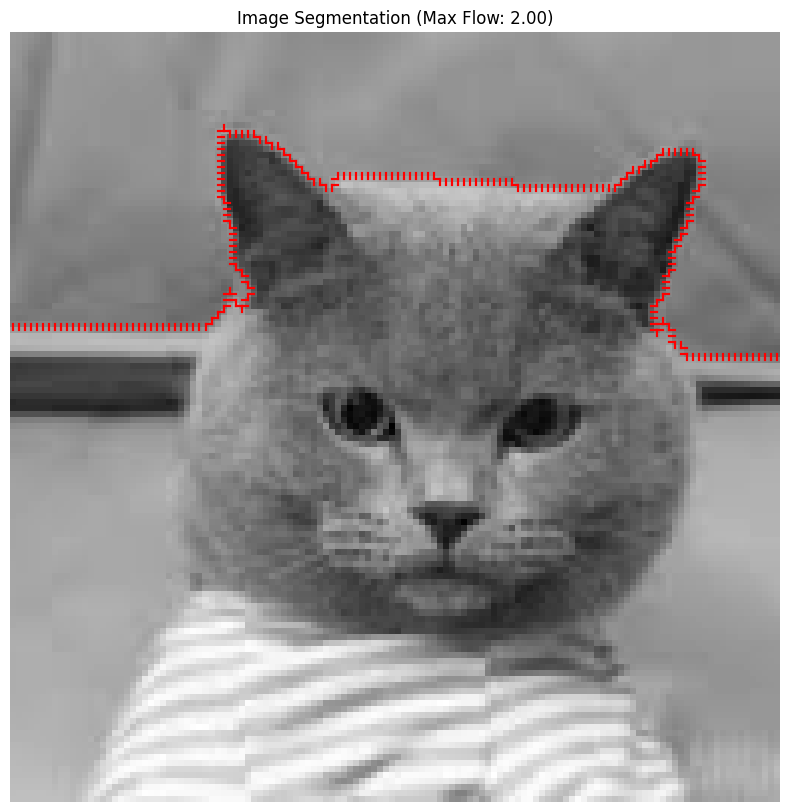

Max Flow: 2.00
Sum of cut capacities: 4.00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

## Variable Declaration - User I/Ps
file_path = 'cat128x128.png'  # Input file name
sigma = 0.001  
background_pixel = (0, 0)  # Background pixel 
foreground_pixel = (70, 70)  # Foreground pixel

## User defined funcs

def load_image(file_path):
    """
    Load an image from a file (.csv or .png).
    If I/P is a .png image, convert it to grayscale (should not have more than 2 dimentions) and numpy array.
    
    Args:
    file_path (str): Path to the image file (.csv or .png)
    
    Returns:
    numpy.ndarray: CSV values or Normalized grayscale image array
    """
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path)
        if img.mode != 'L':  # If not grayscale
            img = img.convert('L')  # Convert to grayscale
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    """
    Create a network representation of the image for max flow / min cut.
    
    Args:
    image (numpy.ndarray): Input image
    sigma (float): Parameter for similarity calculation
    background_pixel (tuple): (row, col) of a background pixel
    foreground_pixel (tuple): (row, col) of a foreground pixel
    
    Returns:
    tuple: (edges, n) where edges is a list of (source, target, capacity) tuples
           and n is the total number of nodes including source and sink
    """
    height, width = image.shape
    n = height * width
    edges = []
    
    # Create edges between neighboring pixels
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:  # 4-neighbours
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    # Add source and sink nodes
    source, sink = n, n+1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    # Connect source to background pixel and foreground pixel to sink
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    """
    Solve the max flow problem using Gurobi optimizer.
    
    Args:
    edges (list): List of (source, target, capacity) tuples
    n (int): Total number of nodes including source and sink
    
    Returns:
    tuple: (model, flow_solution) where model is the Gurobi model and
           flow_solution is a dictionary of optimal flows for each edge
    """
    ojMod = gp.Model("max_flow")
    
    # Create flow variables for each edge
    flow = ojMod.addVars(edges, name="flow")
    
    # Set objective: maximize flow from source
    ojMod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    # Add flow conservation constraints
    for i in range(n-2):  # Exclude source and sink
        ojMod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    # Set capacity constraints
    for e in edges:
        flow[e].ub = e[2]
    
    # Solve the model
    ojMod.Params.OutputFlag = 0 
    ojMod.optimize()
    
    return ojMod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    """
    Find the min cut based on the max flow solution.
    
    Args:
    edges (list): List of (source, target, capacity) tuples
    n (int): Total number of nodes including source and sink
    flow_solution (dict): Optimal flows for each edge
    
    Returns:
    list: List of edges representing the min cut
    """
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    """
    Visualize the image segmentation results.
    
    Args:
    image (numpy.ndarray): Input image
    cuts (list): List of edges representing the min cut
    max_flow (float): Maximum flow value
    """
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()


def image_segmentation(file_path, sigma, background_pixel, foreground_pixel):
    """
    Main execution function to call all UDFs for image segmentation. 
    It will create the network, solve the max flow problem, find the cuts to separate image from background and visualize the results.
    
    Args:
    file_path (str): Path to the image file (.csv or .png)
    image (numpy.ndarray): Input values
    sigma (float): Parameter for similarity calculation
    background_pixel (tuple): (row, col) of a background pixel
    foreground_pixel (tuple): (row, col) of a foreground pixel
    
    Returns:
    None
    """
    
    # I/P
    image = load_image(file_path)

    # N/W Representation & max flow solution
    edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
    ojMod, flow_solution = solve_max_flow(edges, n)
    
    # Find cuts
    cuts = find_cuts(edges, n, flow_solution)
    
    # Results
    visualize_results(image, cuts, ojMod.objVal)
    print(f'Max Flow: {ojMod.objVal:.2f}')
    print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

    return None

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

#### 4-Neighbour implementations

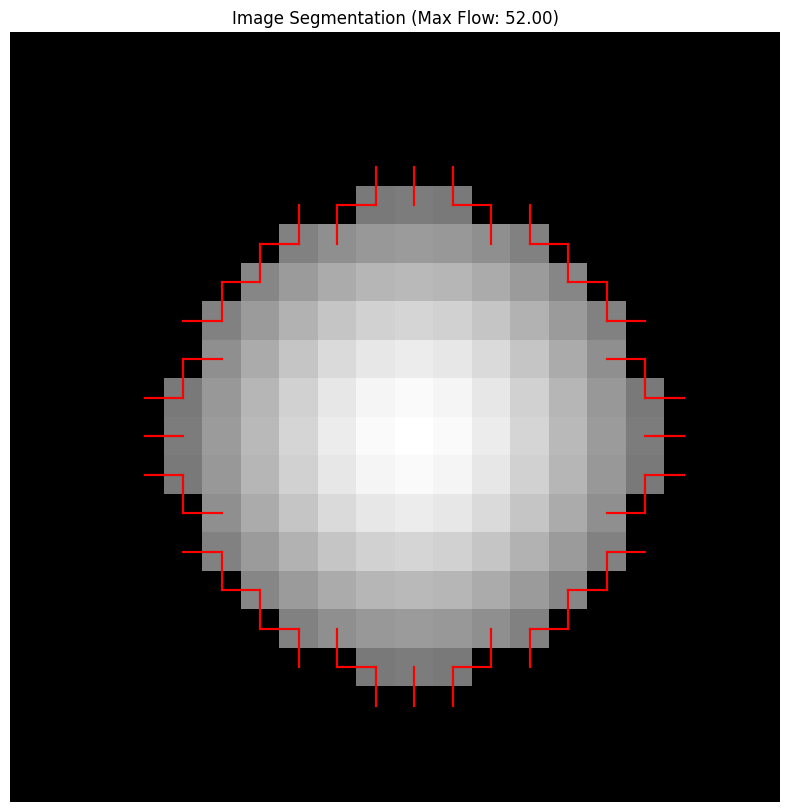

Max Flow: 52.00
Sum of cut capacities: 104.00


In [2]:
## oval-1.csv
file_path = 'oval-1.csv'
sigma = 0.05
background_pixel = (0, 0)
foreground_pixel = (8, 8)

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

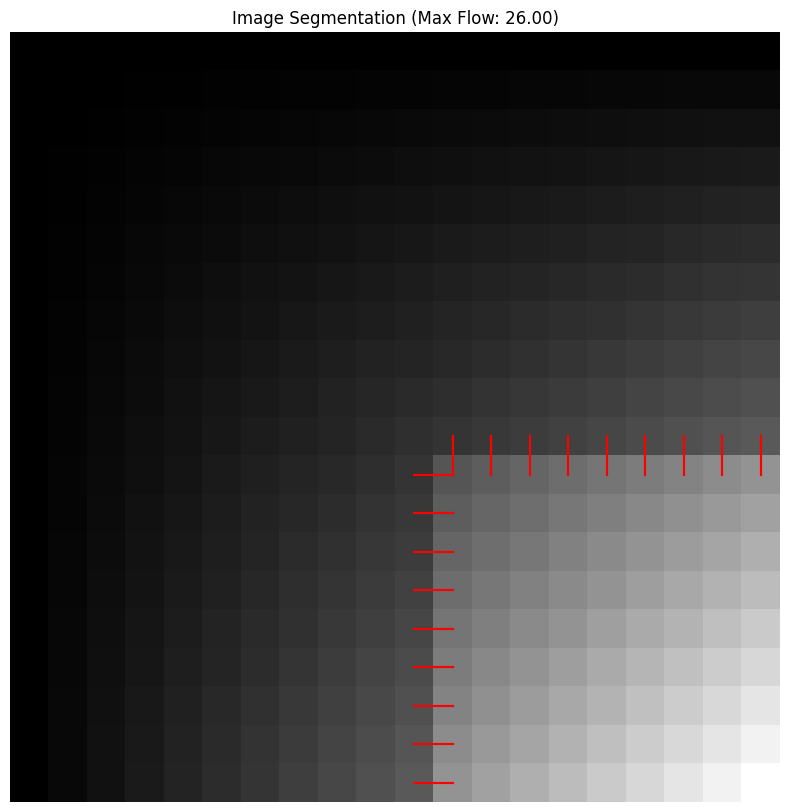

Max Flow: 26.00
Sum of cut capacities: 52.00


In [3]:
# box.csv
# Load image data
file_path = 'box.csv'
sigma = 0.05
background_pixel = (0, 0)
foreground_pixel = (19, 19) 

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

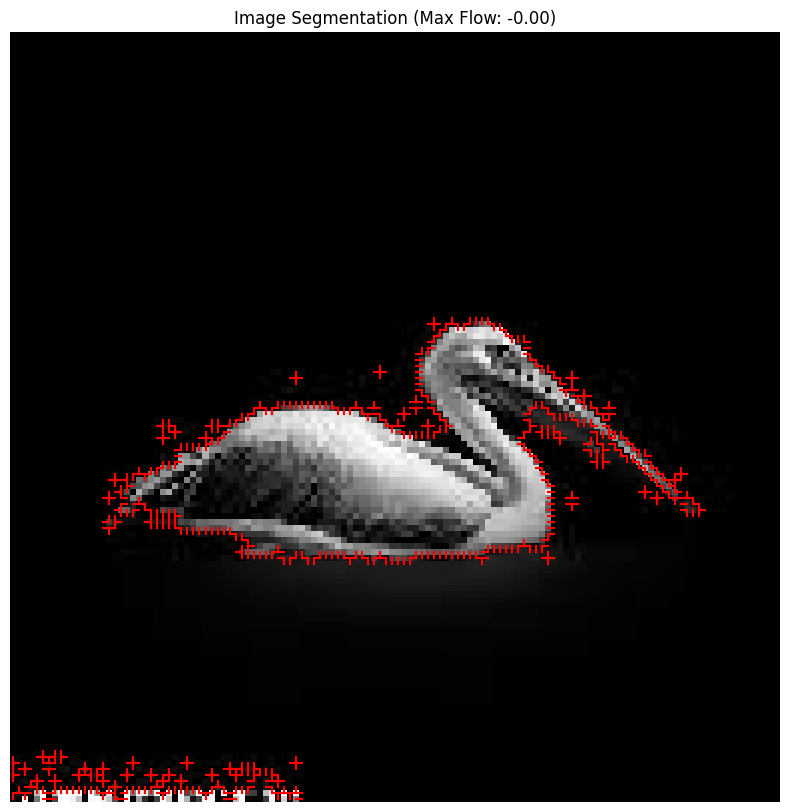

Max Flow: -0.00
Sum of cut capacities: 0.00


In [4]:
## Bird.png
file_path = 'Bird.png'
sigma = 0.001
background_pixel = (0, 0)
foreground_pixel = (70, 70)

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

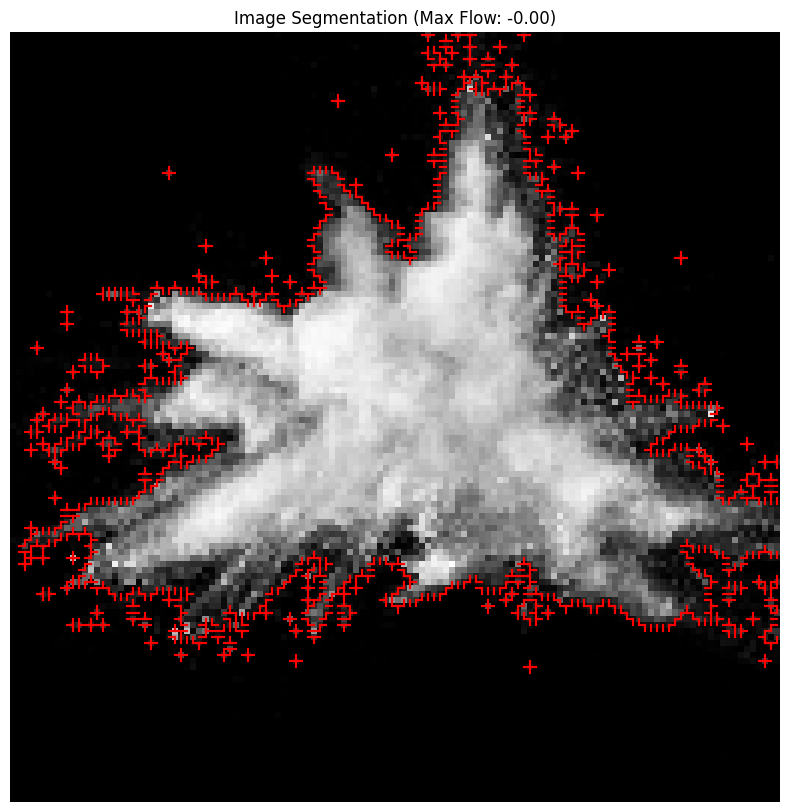

Max Flow: -0.00
Sum of cut capacities: 0.00


In [5]:
## exp.png
file_path = 'exp.png'
sigma = 0.001
background_pixel = (0, 0)
foreground_pixel = (70, 70)

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

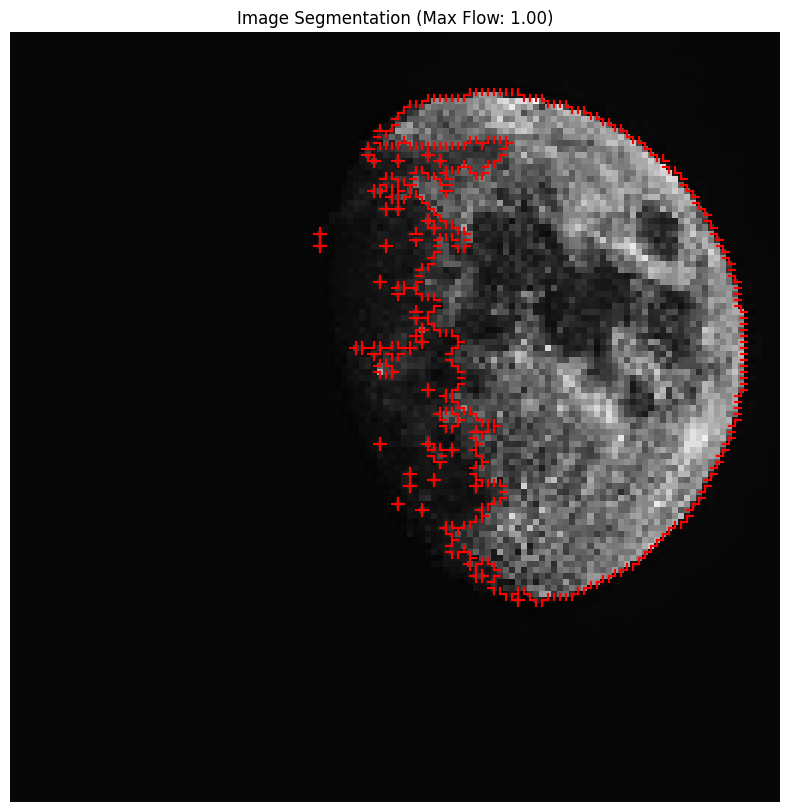

Max Flow: 1.00
Sum of cut capacities: 2.00


In [6]:
## moon-128x128.png
file_path = 'moon-128x128.png'
sigma = 0.001
background_pixel = (0, 0)
foreground_pixel = (70, 70)

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

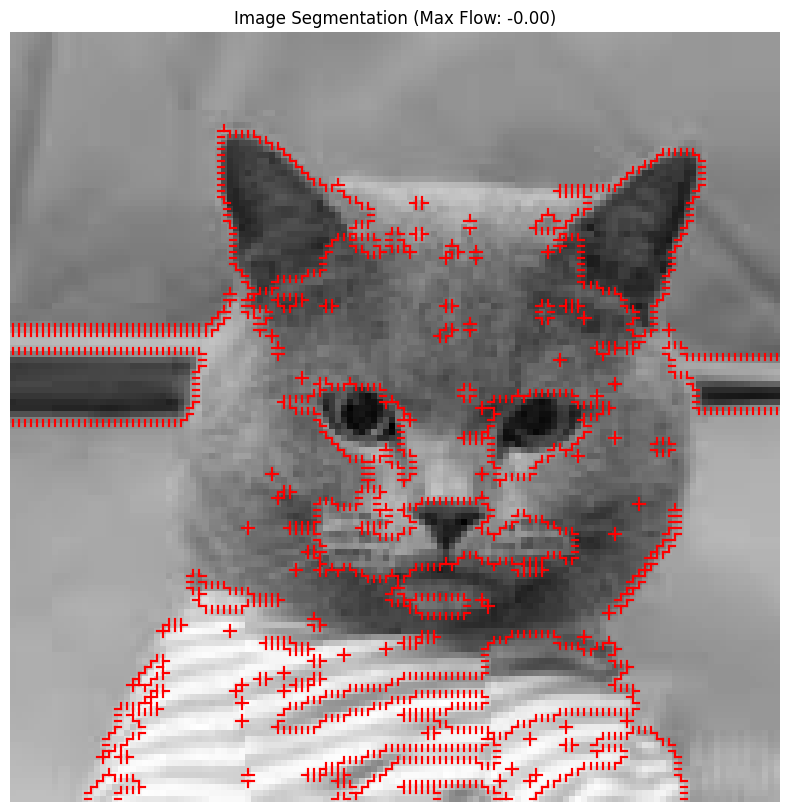

Max Flow: -0.00
Sum of cut capacities: 0.00


In [7]:
## cat.png
file_path = 'cat128x128.png'
sigma = 0.001
background_pixel = (0, 0)
foreground_pixel = (45, 45)

# Function Call
image_segmentation(file_path = file_path
                   , sigma = sigma
                   , background_pixel = background_pixel
                   , foreground_pixel = foreground_pixel)

### 8 neighbours - Including adjacent pixels

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from PIL import Image

def load_image(file_path):
    """
    Load an image from a file (.csv or .png).
    If I/P is a .png image, convert it to grayscale (should not have more than 2 dimensions) and numpy array.
    
    Args:
    file_path (str): Path to the image file (.csv or .png)
    
    Returns:
    numpy.ndarray: CSV values or Normalized grayscale image array
    """
    if file_path.lower().endswith('.csv'):
        return pd.read_csv(file_path, header=None).values
    elif file_path.lower().endswith('.png'):
        img = Image.open(file_path)
        if img.mode != 'L':  # If not grayscale
            img = img.convert('L')  # Convert to grayscale
        return np.array(img) / 255.0  # Normalize to [0, 1]
    else:
        raise ValueError("Unsupported file format. Use CSV or PNG.")

def create_network(image, sigma, background_pixel, foreground_pixel):
    """
    Create a network representation of the image for max flow / min cut.
    
    Args:
    image (numpy.ndarray): Input image
    sigma (float): Parameter for similarity calculation
    background_pixel (tuple): (row, col) of a background pixel
    foreground_pixel (tuple): (row, col) of a foreground pixel
    
    Returns:
    tuple: (edges, n) where edges is a list of (source, target, capacity) tuples
           and n is the total number of nodes including source and sink
    """
    height, width = image.shape
    print(image.shape)
    n = height * width
    edges = []
    
    # Create edges between neighboring pixels
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            
            # Consider 8 neighbors: up, down, left, right, and 4 diagonals
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor = ni * width + nj
                    # Calculate similarity using the provided formula
                    similarity = 100 * np.exp(-((image[i,j] - image[ni,nj])**2) / (2 * sigma**2))
                    # Round up similarity to nearest integer as per instructions
                    edges.append((pixel, neighbor, np.ceil(similarity)))
    
    # Add source and sink nodes
    source, sink = n, n+1
    # Find max similarity among all edges
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    # Connect source to background pixel and foreground pixel to sink
    bg_pixel = background_pixel[0]*width + background_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    
    fg_pixel = foreground_pixel[0]*width + foreground_pixel[1]
    edges.append((fg_pixel, sink, max_similarity))
    
    return edges, n+2

def solve_max_flow(edges, n):
    """
    Solve the max flow problem using Gurobi optimizer.
    
    Args:
    edges (list): List of (source, target, capacity) tuples
    n (int): Total number of nodes including source and sink
    
    Returns:
    tuple: (model, flow_solution) where model is the Gurobi model and
           flow_solution is a dictionary of optimal flows for each edge
    """
    ojMod = gp.Model("max_flow")
    
    # Create flow variables for each edge
    flow = ojMod.addVars(edges, name="flow")
    
    # Set objective: maximize flow from source
    ojMod.setObjective(gp.quicksum(flow[e] for e in edges if e[0] == n-2), GRB.MAXIMIZE)
    
    # Add flow conservation constraints
    for i in range(n-2):  # Exclude source and sink
        ojMod.addConstr(
            gp.quicksum(flow[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow[e] for e in edges if e[0] == i)
        )
    
    # Set capacity constraints
    for e in edges:
        flow[e].ub = e[2]
    
    # Solve the model
    ojMod.Params.OutputFlag = 0 
    ojMod.optimize()
    
    return ojMod, {e: flow[e].X for e in edges}

def find_cuts(edges, n, flow_solution):
    """
    Find the min cut based on the max flow solution.
    
    Args:
    edges (list): List of (source, target, capacity) tuples
    n (int): Total number of nodes including source and sink
    flow_solution (dict): Optimal flows for each edge
    
    Returns:
    list: List of edges representing the min cut
    """
    G = nx.DiGraph()
    for e in edges:
        if e[2] - flow_solution[e] > 1e-6:
            G.add_edge(e[0], e[1])
    
    reachable = set(nx.dfs_preorder_nodes(G, source=n-2))
    cuts = [(u, v) for (u, v, _) in edges if (u in reachable) != (v in reachable)]
    
    return cuts

def visualize_results(image, cuts, max_flow):
    """
    Visualize the image segmentation results.
    
    Args:
    image (numpy.ndarray): Input image
    cuts (list): List of edges representing the min cut
    max_flow (float): Maximum flow value
    """
    height, width = image.shape
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    for u, v in cuts:
        y1, x1 = divmod(u, width)
        y2, x2 = divmod(v, width)
        plt.plot([x1, x2], [y1, y2], 'r-')
    plt.title(f'Image Segmentation (Max Flow: {max_flow:.2f})')
    plt.axis('off')
    plt.show()

def image_segmentation(file_path, sigma, background_pixel, foreground_pixel):
    """
    Main execution function to call all UDFs for image segmentation. 
    It will create the network, solve the max flow problem, find the cuts to separate image from background and visualize the results.
    
    Args:
    file_path (str): Path to the image file (.csv or .png)
    sigma (float): Parameter for similarity calculation
    background_pixel (tuple): (row, col) of a background pixel
    foreground_pixel (tuple): (row, col) of a foreground pixel
    
    Returns:
    None
    """
    
    # Load the image
    image = load_image(file_path)

    # Create network representation
    edges, n = create_network(image, sigma, background_pixel, foreground_pixel)
    
    # Solve max flow problem
    ojMod, flow_solution = solve_max_flow(edges, n)
    
    # Find cuts
    cuts = find_cuts(edges, n, flow_solution)
    
    # Visualize results
    visualize_results(image, cuts, ojMod.objVal)
    
    # Print results
    print(f'Max Flow: {ojMod.objVal:.2f}')
    print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

    return None

(20, 20)


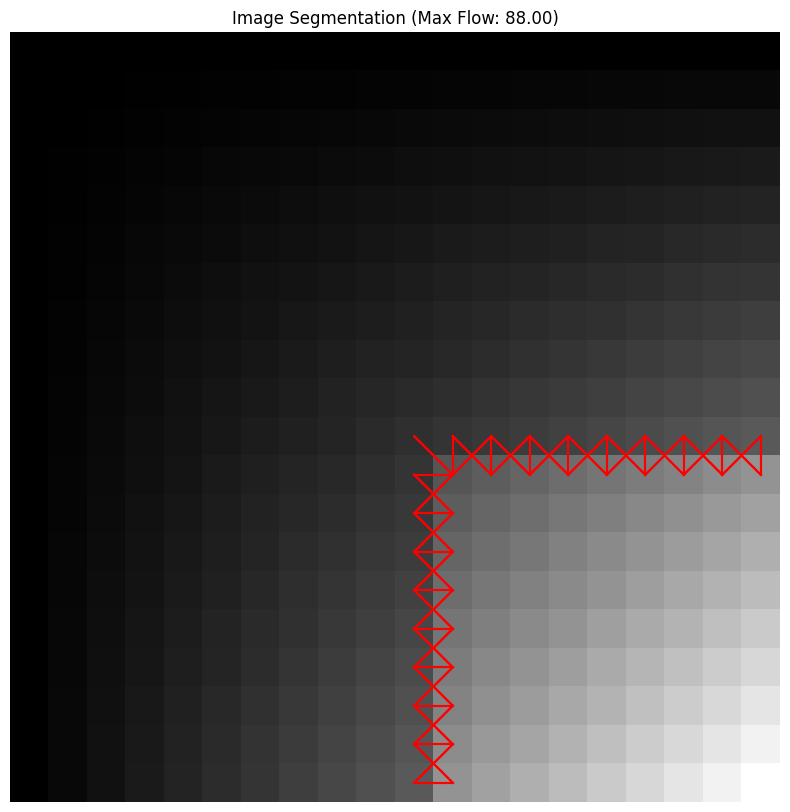

Max Flow: 88.00
Sum of cut capacities: 176.00


In [9]:
# User I/Ps
file_path = 'box.csv'  
sigma = 0.05
background_pixel = (0, 0) 
foreground_pixel = (19, 19)

# Run image segmentation
image_segmentation(file_path, sigma, background_pixel, foreground_pixel)

(128, 128)


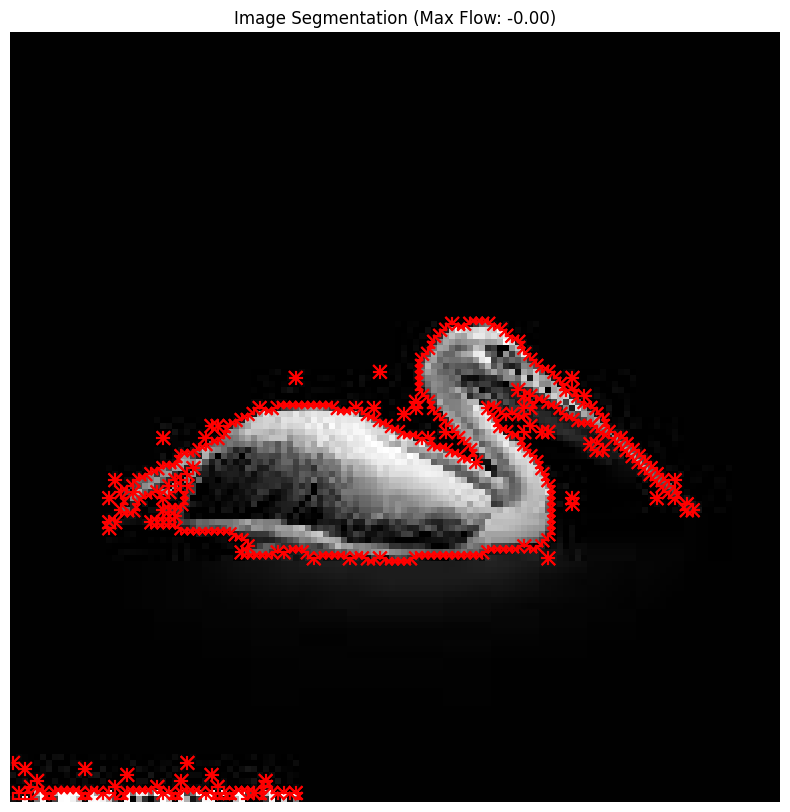

Max Flow: -0.00
Sum of cut capacities: 0.00


In [10]:
# User I/P
file_path = 'Bird.png'  
sigma = 0.001
background_pixel = (0, 0) 
foreground_pixel = (70, 70)

# Run image segmentation
image_segmentation(file_path, sigma, background_pixel, foreground_pixel)

(128, 128)


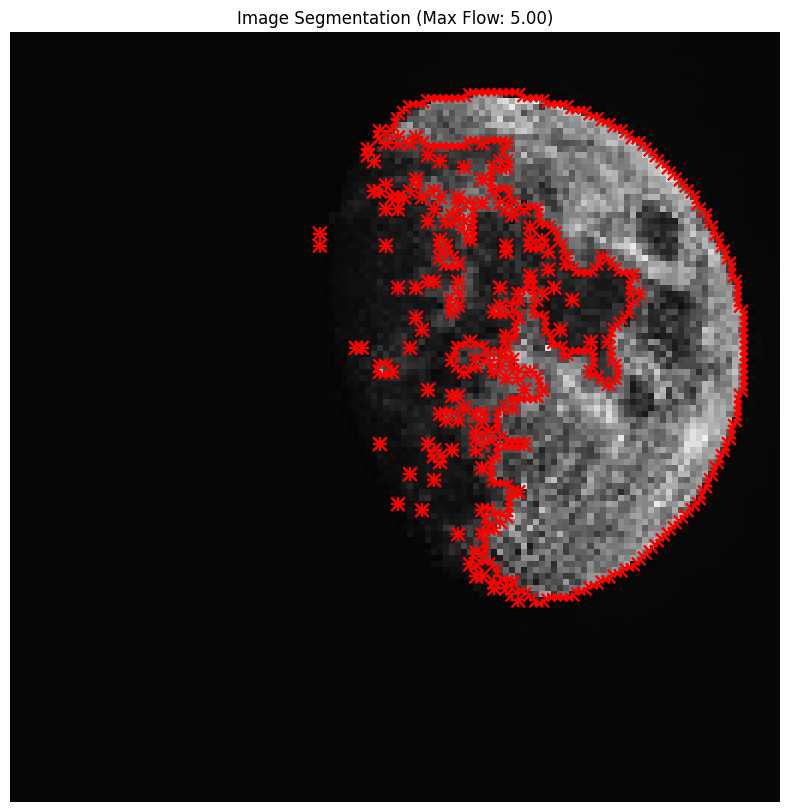

Max Flow: 5.00
Sum of cut capacities: 10.00


In [11]:
# User I/P
file_path = 'Moon-128x128.png'  
sigma = 0.001
background_pixel = (0, 0) 
foreground_pixel = (70, 70)

# Run image segmentation
image_segmentation(file_path, sigma, background_pixel, foreground_pixel)

### End of Report